# Exploring the reference database
Let's see what properties we can find :)

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


## Content of each species/strand folder
In each folder there's:
- .ASN with 
 - `taxname "Acetobacter pasteurianus IFO 3283-32"`
 - `db "taxon", tag id 634457`
 - `genus "Acetobacter", species "pasteurianus"`
 - `mod { {subtype strain, subname "IFO 3283" }, { subtype substrain, subname "IFO 3283-32" } },`
 - `lineage "Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Acetobacteraceae; Acetobacter",`
- .FAA
 - with multiple ">gi|384064451|ref|YP_005479409.1| hypothetical protein APA32_44160 [Acetobacter pasteurianus IFO 3283-32]"
 - and probably the amino-acid sequence for each of these proteins
- .FFN
 - multiple ">gi|384064450|ref|NC_017102.1|:c562-116 Acetobacter pasteurianus IFO 3283-32 plasmid pAPA32-040, complete sequence"
 - probably DNA sequence
- .FNA
 - Also DNA
- .GBK : Human readable format with most info !
 - have an identifier `/db_xref="taxon:634457"`
- .GFF with `##species http://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=634457`
- .RPT
 - seem good with simple Python INI config file format: 
   - `DNA  length = 3035`
   - `Taxname: Acetobacter pasteurianus IFO 3283-32`
   - `Taxid: 634457`


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

#### File marker
https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_accession_numbers_and_mole/?report=objectonly <br>
`NC_	Genomic	Complete genomic molecule, usually reference assembly`

#### Status
https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_status_codes/?report=objectonly <br>
in `COMMENT` : VALIDATED > REVIEWED > PROVISIONAL > ...


## Coding
### Import and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import configparser
import pickle
from Bio import SeqIO
from time import time
from tqdm import tqdm_notebook as tqdm

In [381]:
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
path_ref_db = "/mnt/genomeDB/ncbi/genomes/Bacteria/"
path_kmer_freq = "/home/sjriondet/Data/Kmer_frequencies/"

In [3]:
os.chdir(path_ref_db)

## Functions

In [4]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val

## Tests

In [5]:
path_4mer = "4_V3/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [16]:
names = []
files = []
counts = []
for f in os.scandir(path_4mer):
    if f.name.endswith(".pd"):
        with open(f, 'rb') as file:
            files.append(f.path)
            names.append(os.path.splitext(f.name)[0])
#             counts.append(pickle.load(file))099
print(f"{len(names)} files")

20 files


In [133]:
df = pd.read_pickle(files[0])

In [134]:
df

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,0,6,8,4,9,3,2,...,5,10,2,5,8,6,6,13,8,14
1,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,1000,2,3,9,3,4,4,...,0,3,2,4,2,1,1,3,2,1
2,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,2000,11,7,5,5,2,5,...,4,1,3,5,2,3,3,2,3,0
3,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,0,13,5,3,4,4,8,...,3,10,8,4,4,5,1,9,7,10
4,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,1000,2,4,3,6,9,6,...,2,1,4,3,0,1,2,3,3,9
5,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,2000,11,6,6,3,7,4,...,7,3,3,3,2,3,1,3,2,1
6,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,0,7,7,7,6,3,4,...,4,6,3,3,6,3,2,9,3,6
7,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,1000,10,3,4,12,1,2,...,5,5,7,3,9,7,3,13,14,10
8,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,2000,10,7,4,6,5,9,...,3,6,4,5,6,1,4,8,4,8
9,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,3000,12,6,11,2,7,2,...,0,4,8,3,1,6,7,3,8,21


In [19]:
kmers_list = df.columns.to_list()[4:]

In [20]:
cols_spe = sorted(list(set(df.columns.to_list()).difference(set(kmers_list))))

In [21]:
cols_spe

['bacteria', 'fna', 'len_genome', 'start']

In [26]:
df_concat = []
for file in files:
    df_concat.append(pd.read_pickle(file))

In [92]:
all_df = pd.concat(df_concat)

In [93]:
all_df.bacteria = all_df.bacteria.astype("category")
all_df.fna = all_df.fna.astype("category")

In [96]:
all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
3482,Acetobacterium_woodii_DSM_1030_uid88073,NC_016894,4044777,3482000,10,6,6,9,7,7,...,8,5,3,6,3,4,5,8,6,8
246,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,240000,6,4,8,4,5,3,...,1,6,0,9,4,5,1,7,4,0
1860,Acetobacter_pasteurianus_IFO_3283_12_uid158379,NC_017108,2904624,1860000,5,5,6,6,7,7,...,2,2,0,7,3,3,4,1,6,5
2860,Acetobacter_pasteurianus_IFO_3283_01_uid59279,NC_013209,2907495,2860000,8,3,3,2,7,1,...,0,7,7,6,4,2,5,9,5,7
2472,Acetobacterium_woodii_DSM_1030_uid88073,NC_016894,4044777,2472000,17,9,4,14,6,4,...,1,9,7,6,2,3,18,13,11,24


In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [97]:
len(kmers_list)

256

In [98]:
pca = PCA(n_components=50)
pca.fit(all_df[kmers_list])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

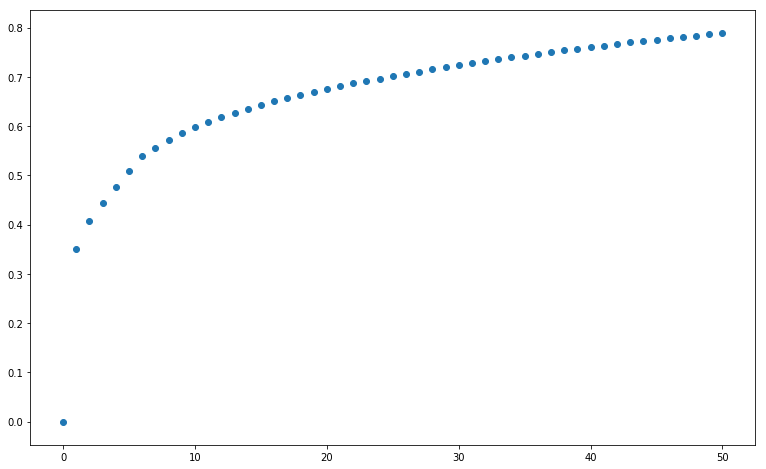

captured by PCA: 78.9%


In [99]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
# plt.plot(pca.explained_variance_ratio_)
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [100]:
pca_n = 10

In [101]:
pca = PCA(n_components=pca_n)
pca.fit(all_df[kmers_list])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [114]:
np_pca = pca.transform(all_df[kmers_list])

In [163]:
cols_pca = [f"pca_{i+1}" for i in range(pca_n)]

In [128]:
df_pca = pd.DataFrame(np_pca, columns=cols_pca)

In [129]:
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)

In [132]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,0,-16.349568,-1.530624,-4.860188,3.532488,-0.619308,8.264006,-3.124179,-0.894617,1.524711,8.683779
1,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,1000,6.081214,-7.256109,0.876697,13.258394,-22.684844,-18.384376,7.535875,1.260226,-2.825298,12.330915
2,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,2000,-5.858122,-4.755307,3.220617,11.091865,-14.832773,-17.828705,0.677731,6.702076,-1.936564,3.042369
3,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,0,-10.473750,-5.314858,0.833240,5.988585,1.484217,1.296763,-5.344260,2.707356,4.510983,2.241737
4,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,1000,6.361165,-6.517096,1.331382,5.958497,3.122433,-11.388546,-0.181509,4.218209,0.802250,4.029840
5,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,2000,3.464062,-5.475840,5.774947,2.435923,-16.183445,-13.307904,-1.254145,1.595875,-4.666632,4.424372
6,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,0,-9.379091,-9.055689,3.306716,4.944684,-4.056496,6.554383,-3.335980,2.456016,-7.986044,4.451489
7,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,1000,-15.351894,0.081397,-7.548168,4.049861,-1.095735,8.532776,-6.862508,-4.140033,6.069180,3.915380
8,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,2000,-18.768133,-2.254491,-10.627284,2.298323,-3.286242,-0.591043,0.689188,-0.482834,-1.214059,1.853929
9,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,3000,-13.271098,-9.242712,4.153126,-5.898722,-1.948438,-7.342988,-4.800390,-4.564730,6.724261,7.425981


In [141]:
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i

In [142]:
df_pca.shape

(75418, 15)

In [143]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,color_map
0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,0,-16.349568,-1.530624,-4.860188,3.532488,-0.619308,8.264006,-3.124179,-0.894617,1.524711,8.683779,0
1,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,1000,6.081214,-7.256109,0.876697,13.258394,-22.684844,-18.384376,7.535875,1.260226,-2.825298,12.330915,0
2,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017102,3204,2000,-5.858122,-4.755307,3.220617,11.091865,-14.832773,-17.828705,0.677731,6.702076,-1.936564,3.042369,0
3,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,0,-10.473750,-5.314858,0.833240,5.988585,1.484217,1.296763,-5.344260,2.707356,4.510983,2.241737,0
4,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,1000,6.361165,-6.517096,1.331382,5.958497,3.122433,-11.388546,-0.181509,4.218209,0.802250,4.029840,0
5,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017103,3035,2000,3.464062,-5.475840,5.774947,2.435923,-16.183445,-13.307904,-1.254145,1.595875,-4.666632,4.424372,0
6,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,0,-9.379091,-9.055689,3.306716,4.944684,-4.056496,6.554383,-3.335980,2.456016,-7.986044,4.451489,0
7,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,1000,-15.351894,0.081397,-7.548168,4.049861,-1.095735,8.532776,-6.862508,-4.140033,6.069180,3.915380,0
8,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,2000,-18.768133,-2.254491,-10.627284,2.298323,-3.286242,-0.591043,0.689188,-0.482834,-1.214059,1.853929,0
9,Acetobacter_pasteurianus_IFO_3283_32_uid158375,NC_017111,2904642,3000,-13.271098,-9.242712,4.153126,-5.898722,-1.948438,-7.342988,-4.800390,-4.564730,6.724261,7.425981,0


In [84]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 13, 8

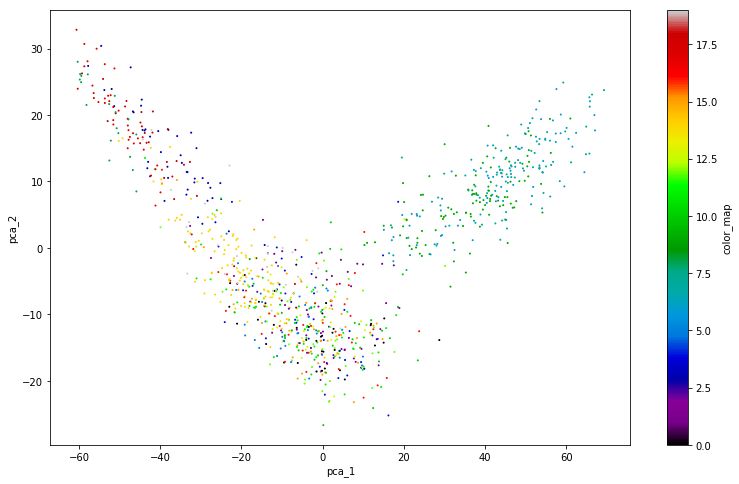

captured by PCA: 40.8%


In [150]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

## Machine Learning classification

In [175]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, scale

In [192]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [286]:
df_pca1000 = df_pca.sample(10000, random_state=0)

In [342]:
X_train, X_test, y_train, y_test = train_test_split(scale(df_pca1000[cols_pca]), df_pca1000.bacteria.to_list(), test_size=0.1, random_state=0)

In [288]:
df_pca.sample(5)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,color_map
38104,Achromobacter_xylosoxidans_A8_uid59899,NC_014640,7013095,5415000,39.021009,4.252767,-3.971797,-2.991652,-3.302860,-4.409731,5.235342,1.028774,5.594871,5.823225,9
11177,Acetobacterium_woodii_DSM_1030_uid88073,NC_016894,4044777,4019000,-36.008729,12.597204,-10.355042,-7.169450,12.261810,12.862301,-20.601201,8.607170,0.775104,2.402034,3
63372,Acetobacter_pasteurianus_IFO_3283_07_uid158381,NC_017121,2906044,1669000,-6.981006,-16.290613,-4.727470,-10.673960,17.188189,-2.628318,0.104269,-8.519003,-2.903814,2.345525,15
56768,Acaryochloris_marina_MBIC11017_uid58167,NC_009925,6503724,3472000,-22.338535,-0.457360,-0.910466,8.200914,3.614186,3.167972,1.680281,-1.809877,-0.617131,-6.022005,14
18307,Achromobacter_xylosoxidans_NBRC_15126_uid232243,NC_023061,6683584,713000,59.286254,17.582359,9.942921,-1.077894,16.741498,-4.169867,-4.667401,3.138580,-4.313125,1.020105,6


In [343]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [354]:
results = {}

In [355]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        models[name].fit(X_train, y_train)
        score = models[name].score(X_test, y_test)
        predicted = models[name].predict(X_test)
        
        results[name] = {}
        results[name]["time"] = time() - start
        results[name]["score"] = score
        results[name]["predicted"] = predicted
    

RF
SVM_lin
SVM_rbf
KNeigh
DTree
NNet
AdaBoost
Naive_Bayes
QDA


In [346]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

In [388]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [389]:
ranking

RF            42.20
SVM_lin       43.00
SVM_rbf       44.90
KNeigh        45.00
DTree         37.70
NNet          44.30
AdaBoost      26.00
Naive_Bayes   43.20
QDA           42.90
dtype: float64

In [371]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [373]:
pd_ranking["time"] = 0
for name in results.keys():
    pd_ranking.loc[pd_ranking["name"] == name, ['time']] = results[name]["time"]

In [382]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

,name,percentage,time
3,KNeigh,45.00,0.48
2,SVM_rbf,44.90,4.06
5,NNet,44.30,9.85
7,Naive_Bayes,43.20,0.03
1,SVM_lin,43.00,1.93
8,QDA,42.90,0.03
0,RF,42.20,1.00
4,DTree,37.70,0.21
6,AdaBoost,26.00,2.24


In [293]:
pd_res

,Ground_Truth,RF_gotit,RF_pred,SVM_lin_gotit,SVM_lin_pred,SVM_rbf_gotit,SVM_rbf_pred,DTree_gotit,DTree_pred,NNet_gotit,NNet_pred,AdaBoost_gotit,AdaBoost_pred,Naive_Bayes_gotit,Naive_Bayes_pred,QDA_gotit,QDA_pred
0,Acetobacter_pasteurianus_IFO_3283_22_uid158383,0,Acetobacter_pasteurianus_IFO_3283_01_uid59279,0,Acetobacter_pasteurianus_IFO_3283_12_uid158379,0,Acetobacter_pasteurianus_IFO_3283_01_uid59279,0,Acetobacter_pasteurianus_386B_uid214433,0,Acetobacter_pasteurianus_IFO_3283_12_uid158379,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acetobacter_pasteurianus_386B_uid214433,0,Acetobacter_pasteurianus_IFO_3283_01_uid59279
1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167
2,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,0,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255
3,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_A8_uid59899
4,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167,0,Acetobacter_pasteurianus_386B_uid214433,1,Acaryochloris_marina_MBIC11017_uid58167,0,Acidilobus_saccharovorans_345_15_uid51395,1,Acaryochloris_marina_MBIC11017_uid58167,1,Acaryochloris_marina_MBIC11017_uid58167
5,Achromobacter_xylosoxidans_uid205255,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_uid205255,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899
6,Achromobacter_xylosoxidans_NBRC_15126_uid232243,0,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_NBRC_15126_uid232243,1,Achromobacter_xylosoxidans_NBRC_15126_uid232243,0,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_NBRC_15126_uid232243,0,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_NBRC_15126_uid232243,1,Achromobacter_xylosoxidans_NBRC_15126_uid232243
7,Acetobacter_pasteurianus_IFO_3283_03_uid158373,0,Acetobacter_pasteurianus_IFO_3283_22_uid158383,0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,0,Acetobacter_pasteurianus_IFO_3283_22_uid158383,0,Acetobacter_pasteurianus_IFO_3283_32_uid158375,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acetobacter_pasteurianus_IFO_3283_01_uid59279,0,Acetobacter_pasteurianus_IFO_3283_01_uid59279
8,Achromobacter_xylosoxidans_uid205255,1,Achromobacter_xylosoxidans_uid205255,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,1,Achromobacter_xylosoxidans_uid205255,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899,0,Achromobacter_xylosoxidans_A8_uid59899
9,Acetobacter_pasteurianus_IFO_3283_32_uid158375,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochloris_marina_MBIC11017_uid58167,0,Acaryochl

In [229]:
def randForest():
    if verbose:  print("Random Forest Classification")
    rf_regr = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6)
    rf_regr.fit(X_train, y_train)
    return rf_regr

In [230]:
rf_cl = randForest()
score = rf_cl.score(X_test, y_test)
score

Random Forest Classification


0.48999999999999999

In [233]:
predicted = rf_cl.predict(X_test)

In [235]:
pd_res = pd.DataFrame({"Ground_Truth": y_test, "Got_it": y_test==predicted, "Predicted": predicted})
pd_res

,Ground_Truth,Got_it,Predicted
0,Acetobacter_pasteurianus_IFO_3283_07_uid158381,False,Achromobacter_xylosoxidans_A8_uid59899
1,Acetohalobium_arabaticum_DSM_5501_uid51423,True,Acetohalobium_arabaticum_DSM_5501_uid51423
2,Achromobacter_xylosoxidans_uid205255,False,Achromobacter_xylosoxidans_NBRC_15126_uid232243
3,Achromobacter_xylosoxidans_NBRC_15126_uid232243,True,Achromobacter_xylosoxidans_NBRC_15126_uid232243
4,Achromobacter_xylosoxidans_NBRC_15126_uid232243,True,Achromobacter_xylosoxidans_NBRC_15126_uid232243
5,Acidianus_hospitalis_W1_uid66875,True,Acidianus_hospitalis_W1_uid66875
6,Acetobacter_pasteurianus_IFO_3283_01_uid59279,False,Acetobacter_pasteurianus_IFO_3283_32_uid158375
7,Acholeplasma_laidlawii_PG_8A_uid58901,True,Acholeplasma_laidlawii_PG_8A_uid58901
8,Achromobacter_xylosoxidans_uid205255,True,Achromobacter_xylosoxidans_uid205255
9,Acetohalobium_arabaticum_DSM_5501_uid51423,True,Acetohalobium_arabaticum_DSM_5501_uid51423


In [180]:
def svr():
    if verbose:  print("Support Vector Machine regression")
    svr_rbf = SVC(kernel='rbf', gamma='auto', cache_size=1000)
    svr_rbf.fit(X_train, y_train)
    return svr_rbf

In [181]:
svr_rbf = svr()
svr_pred = error_and_corr(svr_rbf)
some_predictions(svr_pred)

Support Vector Machine regression
Pearson correlation	: *0.396*
Mean squared error	: 450474419.036
Expected values 	: 20750.00	60975.00	6943.00	43743.00	37827.00	35247.00	14456.00	20457.00	63387.00	64819.00
Predicted values 	: 36217.67	41153.16	37715.84	40516.99	37342.60	37451.71	40153.87	36616.17	39658.96	39800.07


In [182]:
def k_neigh():
    if verbose:  print("K neighbours")
    neigh = KNeighborsRegressor(n_neighbors=20, n_jobs=6)
    neigh.fit(X_train, y_train)
    return neigh

In [183]:
neigh = k_neigh()
n_pred = error_and_corr(neigh)
some_predictions(n_pred)

K neighbours
Pearson correlation	: *0.671*
Mean squared error	: 260134584.829
Expected values 	: 20750.00	60975.00	6943.00	43743.00	37827.00	35247.00	14456.00	20457.00	63387.00	64819.00
Predicted values 	: 26281.15	56710.45	5391.20	32758.30	32224.10	27731.05	38815.25	26915.65	37706.80	40203.70


In [ ]:
def elas_net():
    if verbose:  print("Elastic Net")
    elastic_net = ElasticNet(l1_ratio=0.5, random_state=0)
    elastic_net.fit(X_train, y_train)
    return elastic_net

In [ ]:
e_net = elas_net()
e_pred = error_and_corr(e_net)
some_predictions(e_pred)

In [ ]:
def nn():
    if verbose:  print("Neural Network")
    nnm = MLPRegressor(hidden_layer_sizes=(100,100,), verbose=False, tol=0.000100)
    nnm.fit(X_train, y_train)
    return nnm

In [ ]:
nn_m = nn()
nn_pred = error_and_corr(nn_m)
some_predictions(nn_pred)

In [ ]:
models = [linReg, randForest, svr, k_neigh, elas_net, nn]

In [ ]:
results = {}
for model in tqdm(models):
    print("******************************************")
    m = model()
    pred = error_and_corr(m)
    # some_predictions(pred)
    pearson, err = error_and_corr(m, re_val=True)
    results[model.__name__] = {"pearson": pearson, "err": err}

In [ ]:
pred = error_and_corr(models[1](), display=False)

In [ ]:
pd.DataFrame([pred, y_test.values])

In [ ]:
from datetime import datetime
file_results = "results.csv"
file_results = osp.join(folder, file_results)

In [ ]:
with open(file_results, "a") as f:
    f.write(str(datetime.now())[:16] + "," + str(param) + "," + "\n")
    f.write(",".join(results.keys()) + "\n")
    f.write(",".join([f"{v['pearson']:.3f}" for v in results.values()]) + "\n")
    f.write(",".join([f"{v['err']:.3f}" for v in results.values()]) + "\n")
    print(f"Results written in {file_results}")

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [198]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [206]:
results = {}
for name, clf in tqdm(zip(names, classifiers), total=len(names), desc="Classifiers"):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    results[name] = score

KeyboardInterrupt: 



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

In [159]:
def scale_minmax(df, single_col=False):
    df = df + 1
    df = df.apply(np.log2)
    if single_col:
        return MinMaxScaler().fit_transform(df.values.reshape(-1, 1))
    else:
        return MinMaxScaler().fit_transform(df)

In [160]:
def error_and_corr(model, display=True, re_val=False):
    prediction = model.predict(X_test)
    pearson = np.corrcoef(prediction, y_test)[0, 1]
    mean_square_err = mean_squared_error(y_test, prediction)
    if re_val:
        return pearson, mean_square_err
    if display:
        print(f"Pearson correlation\t: *{pearson:.3f}*")
        print(f"Mean squared error\t: {mean_square_err:.3f}")
    return prediction

In [161]:
def some_predictions(pred):
    print("Expected values \t: " + "\t".join([f"{n:.2f}" for n in y_test[:10]]))
    print("Predicted values \t: " + "\t".join([f"{n:.2f}" for n in pred[:10]]))

kmers stuff

In [ ]:
def window(fseq, window_size=53):
    for i in range(len(fseq) - window_size + 1):
        yield fseq[i:i+window_size]

In [ ]:
def kmer_pkl_path(k, fna_path):
    path_gbk = fna_path.replace(".fna", ".gbk")
    assert os.path.isfile(path_gbk), f"{fna_path} DOESN'T have a .gbk file ??"
    
    with open(path_gbk) as gbk:
        description=gbk.read()  #.replace('\n', '')
        
    identificator = 'db_xref="taxon:'
    taxo_start = description.find(identificator)
    taxo = description[taxo_start+len(identificator):
                       taxo_start+description[taxo_start:].find('"\n')]
    assert len(taxo) < 10, f"The taxo id search failed, found an id of length {len(taxo)}..."
    
    # TODO: ADD full path of the original file in the file name, or maybe in the .pkl
    
    return os.path.join(path_kmer_freq, str(k), taxo + ".pkl")

In [ ]:
def kmer_freq_to_file(kmer_dic, freq_path):
    with open(freq_path, 'wb') as f_out:
        pickle.dump(kmer_dic, f_out)